# Ensembles Classifiers using Trees on the Loan Dataset

In this notebook we apply several ensemble methods to the loan dataset we used in other examples.

First we load all the required libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constructs a new estimator with the same parameters.
# Clone does a deep copy of the model in an estimator 
# without actually copying attached data. It yields a 
# new estimator with the same parameters that has not 
# been fit on any data.
from sklearn import clone 

from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,BaggingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Next we define some of the parameters required to run the experiments like the number of estimators used in each ensembles and the random seed to be able to reproduce the results.

In [3]:
# Set the random seed to be able to repeat the experiment
random_seed = 42 

Load the loans dataset, define the variable $y$, and the input variables $x$

In [4]:
loans = pd.read_csv('LoansNumerical.csv')
target = 'safe_loans'
features = loans.columns[loans.columns!=target]

x = loans[features]
y = loans[target]

Set the models to be compared
- Simple Decision Tree
- Bagging
- Random Forest
- AdaBoost

In [5]:
models = {'Decision Tree':DecisionTreeClassifier(),
          'Bagging':BaggingClassifier(DecisionTreeClassifier()),
          'Random Forest':RandomForestClassifier(),
          'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier())}

For each model, we apply 10-fold stratified crossvalidation and compute the average accuracy and the corresponding standard deviation

In [6]:
folds = StratifiedKFold(n_splits=10,shuffle=True,random_state=random_seed)
scores = {}
for model_name in models:
    clf = models[model_name];
    score = cross_val_score(clf,x,y,cv=folds)
    scores[model_name]=(np.average(score),np.std(score))
    print('\t%26s\t%.3f +/- %.3f'%(model_name,scores[model_name][0],scores[model_name][1]))

	                   Bagging	0.792 +/- 0.003
	                 Ada Boost	0.729 +/- 0.003
	             Random Forest	0.798 +/- 0.002
	             Decision Tree	0.729 +/- 0.003


## Ensemble using k-nearest neighbors
We now applt Bagging using k-nearest neighbors as the base classifier. Note that we use only Baggin and Ada Boost since Random Forest and Extra Trees are bound to decision trees; we cannot use Ada Boost since the k-nearest-neighbor implementation does not support the sample weights that are needed by Ada Boost.

In [10]:
k = 10
knn_models = {'k-Nearest Neighbors':KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree'),
          'Bagging':BaggingClassifier(KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree'))}

In [11]:
folds = StratifiedKFold(n_splits=5,shuffle=True,random_state=random_seed)

scores = {}

for model_name in knn_models:
    clf = clone(knn_models[model_name]);
    score = cross_val_score(clf,x,y,cv=folds)
    scores[model_name]=(np.average(score),np.std(score))
    print('\t%26s\t%.3f +/- %.3f'%(model_name,scores[model_name][0],scores[model_name][1]))

	       k-Nearest Neighbors	0.792 +/- 0.001
	                   Bagging	0.801 +/- 0.001


## Voting classifiers
We can build our own ensembles by computing a set of heterogeneous models and then, to compute a class, first we compute the output of all the models and use the majority voting.

In [12]:
estimators = [
        ('k-Nearest Neighbors', KNeighborsClassifier(n_neighbors=16, algorithm='kd_tree')), 
        ('Decision Tree', DecisionTreeClassifier(max_depth=None)), 
        ('Logistic Regression', LogisticRegression(random_state=random_seed)),
        ('Bagging', BaggingClassifier(DecisionTreeClassifier(max_depth=3))),
        ('Random Forest',RandomForestClassifier()),
        ('Ada Boost',AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)))
    ]

In [13]:
for (label,model) in estimators:
    scores = cross_val_score(clone(model), x, y, cv=folds, scoring='accuracy')
    print('\t%26s\t%.3f +/- %.3f'%(label,np.average(scores),np.std(scores)))

	       k-Nearest Neighbors	0.804 +/- 0.001
	             Decision Tree	0.728 +/- 0.002
	       Logistic Regression	0.813 +/- 0.001
	                   Bagging	0.815 +/- 0.001
	             Random Forest	0.798 +/- 0.002
	                 Ada Boost	0.820 +/- 0.001


In [14]:
voting = VotingClassifier(estimators=estimators)
scores = cross_val_score(voting, x, y, cv=folds, scoring='accuracy')
print('\t%26s\t%.3f +/- %.3f'%('Voting',np.average(scores),np.std(scores)))

	                    Voting	0.820 +/- 0.001


## Variable Importance
Ensembles generate models that are difficult to analyze but provide interesting ways to score the variable used by all the models in the ensembles.

In [16]:
fitted = {}
for model_name in models:
    model = clone(models[model_name])
    score = model.fit(x,y)
    if(model_name != 'Bagging'):
        fitted[model_name] = (model,score,model.feature_importances_)

Then we plot the variable importances

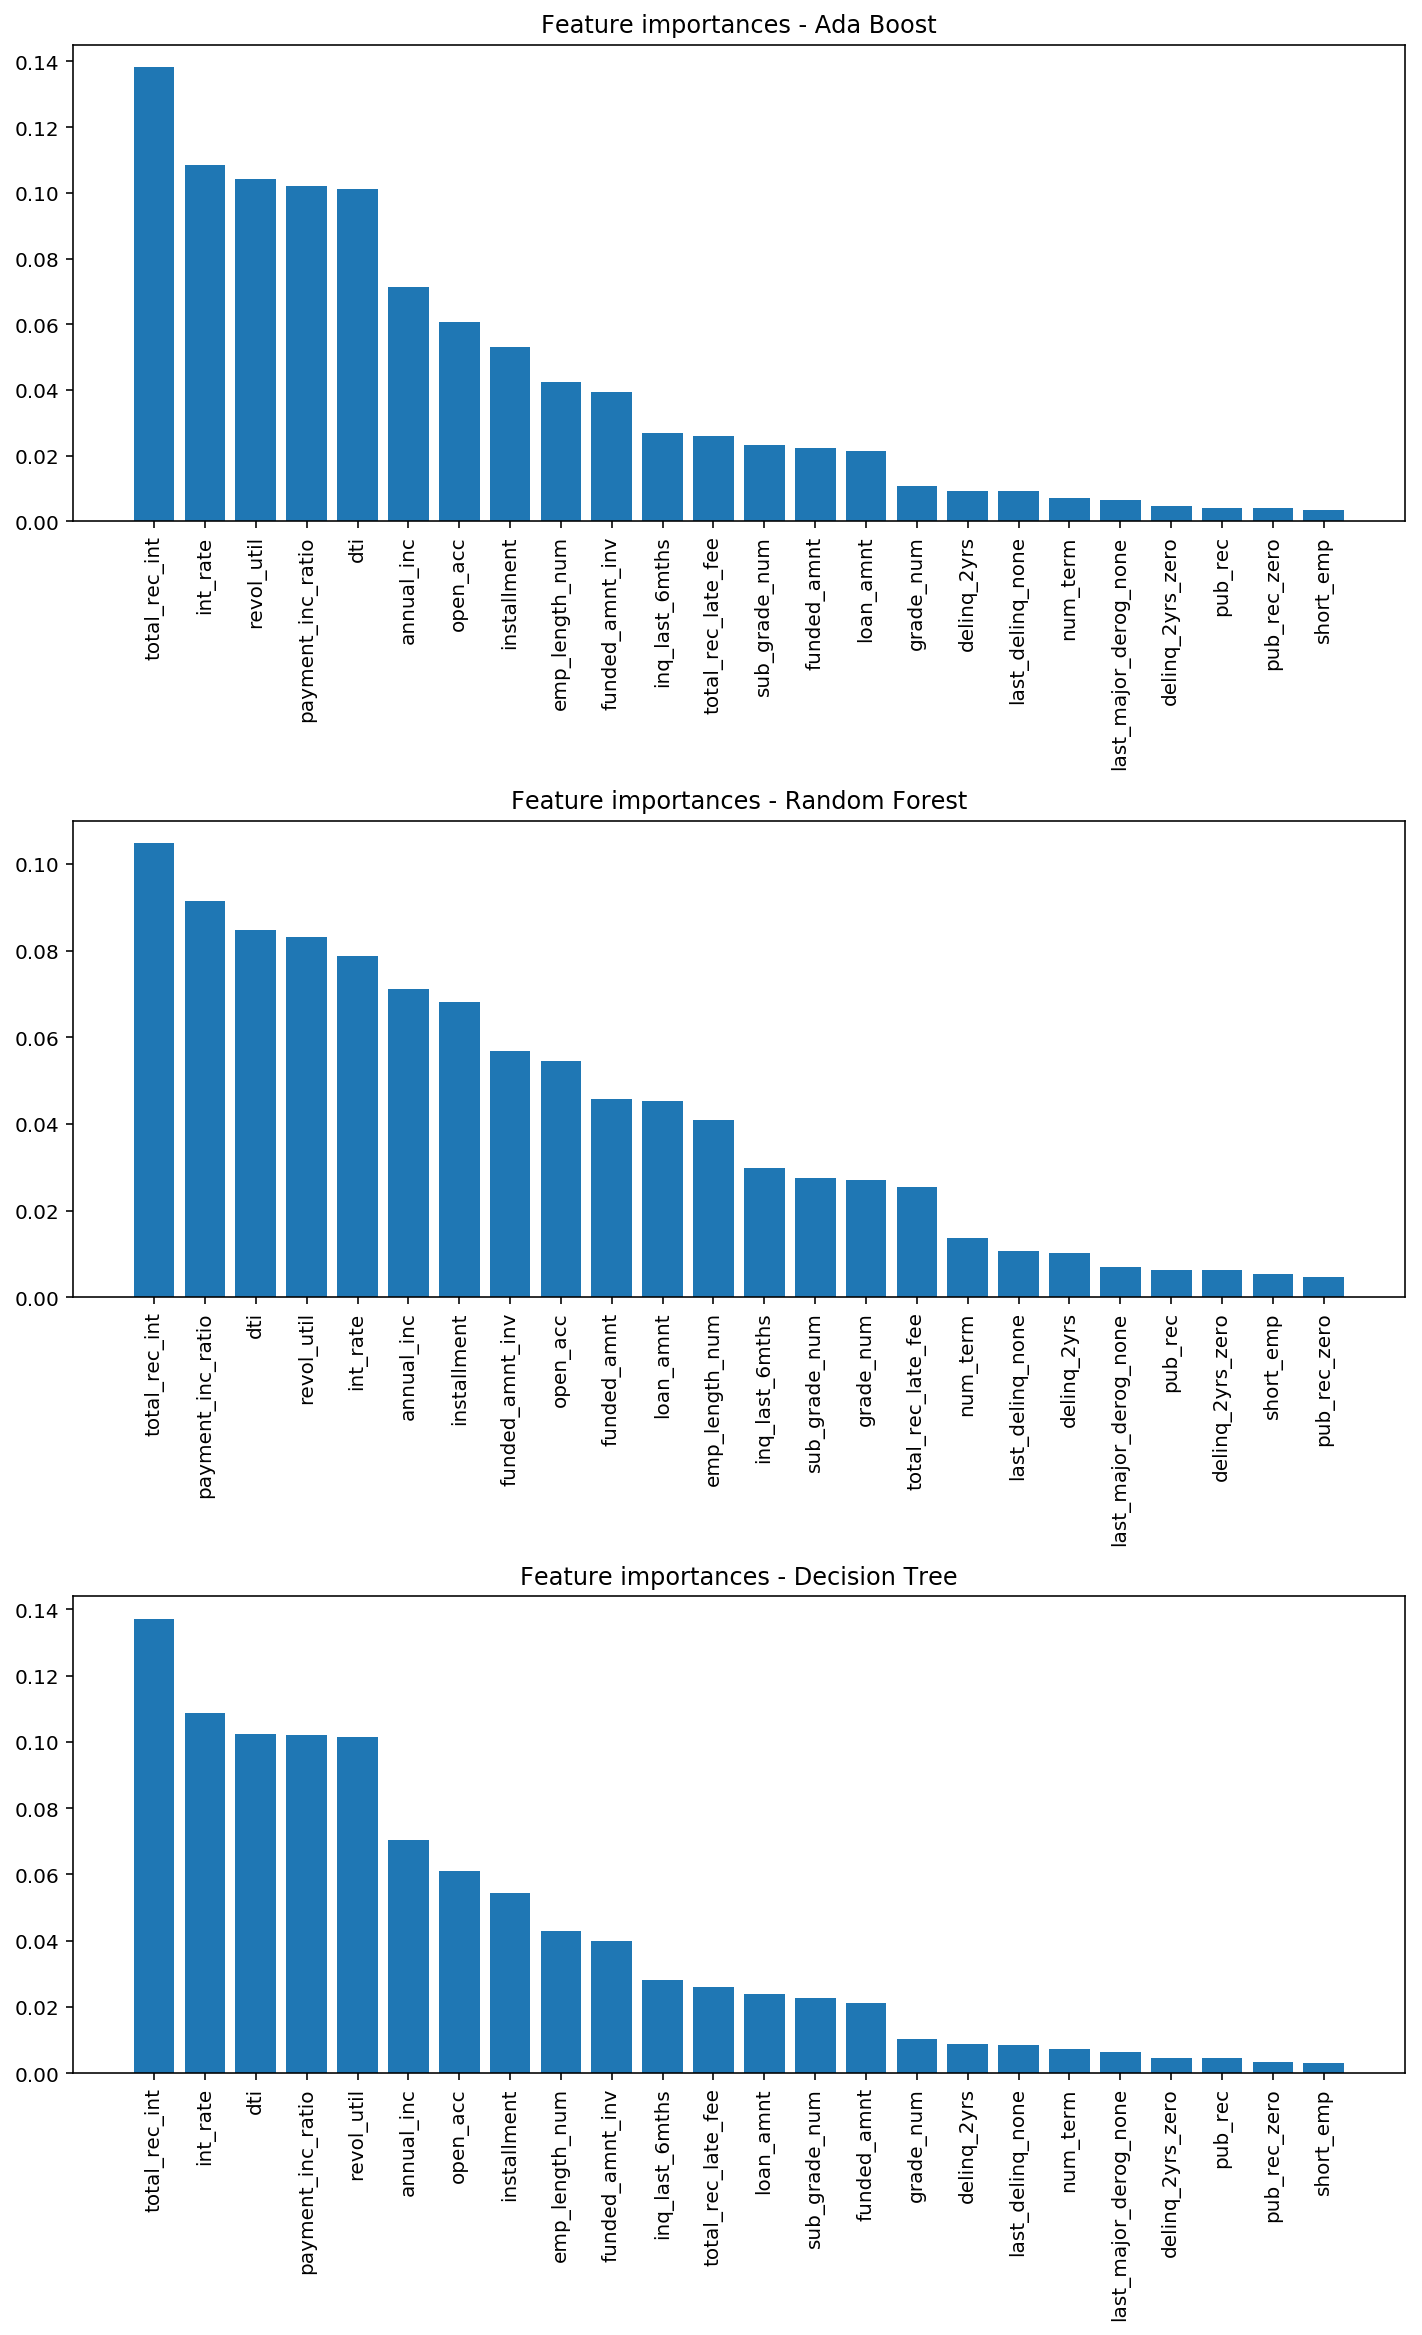

In [17]:
plot_idx = 1
plt.figure(figsize=(10,20))
for model_name in fitted:
    plt.subplot(4,1,plot_idx)
    importances = fitted[model_name][2]
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances 
    plt.title("Feature importances - "+model_name)
    plt.xticks(range(x.shape[1]),x.columns[indices],rotation='vertical')
    
    plt.bar(range(x.shape[1]), importances[indices],align="center")
    plot_idx = plot_idx + 1

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None)
plt.show()